In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# data preprocessing
# Resize image size as 54 * 64 and change type to Tensor
# Normalize the data
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# train, validation, test data loading
train_dataset = datasets.ImageFolder(root='./dataset/train', transform=data_transform)
val_dataset = datasets.ImageFolder(root='./dataset/val', transform=data_transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=data_transform)

#set batch size as 32, shuffle = True
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [8]:
# Make MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(64*64*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 11)


    def forward(self, x):
        x = x.view(-1, 64*64*3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()

In [9]:
# set criterion as crossentropyloss
# set optimizer as Adam, learning late = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# list that save train and validation accuracy every epoch
train_acc_list = []
val_acc_list = []

#set epoch as 20
epochs = 20

# learning
for epoch in range(epochs): 
    model.train()
    train_correct = 0
    train_total = 0
    run_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    train_acc = 100 * train_correct / train_total
    train_acc_list.append(train_acc)


    # Evaluation
    model.eval()
    val_correct = 0
    val_total = 0

    # For disabling Autograd in PyTorch
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)
    print(f'Epoch {epoch + 1}, Loss: {run_loss / len(train_loader)}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%')


Epoch 1, Loss: 1.8906760087151746, Train Accuracy: 28.17%, Val Accuracy: 30.73%
Epoch 2, Loss: 1.6575369815114127, Train Accuracy: 35.99%, Val Accuracy: 30.18%
Epoch 3, Loss: 1.5215977059360362, Train Accuracy: 40.91%, Val Accuracy: 30.27%
Epoch 4, Loss: 1.3981415735735438, Train Accuracy: 46.16%, Val Accuracy: 31.55%
Epoch 5, Loss: 1.243797294331784, Train Accuracy: 53.06%, Val Accuracy: 32.45%
Epoch 6, Loss: 1.0805177747955956, Train Accuracy: 60.61%, Val Accuracy: 34.73%
Epoch 7, Loss: 0.9247265137824775, Train Accuracy: 66.53%, Val Accuracy: 36.18%
Epoch 8, Loss: 0.7703639148923866, Train Accuracy: 72.17%, Val Accuracy: 32.82%
Epoch 9, Loss: 0.6450555657202772, Train Accuracy: 76.99%, Val Accuracy: 32.09%
Epoch 10, Loss: 0.531068789637435, Train Accuracy: 81.04%, Val Accuracy: 34.73%
Epoch 11, Loss: 0.45611213020887614, Train Accuracy: 84.19%, Val Accuracy: 32.55%
Epoch 12, Loss: 0.3872461290836829, Train Accuracy: 86.90%, Val Accuracy: 33.64%
Epoch 13, Loss: 0.3579516230127871, Tr

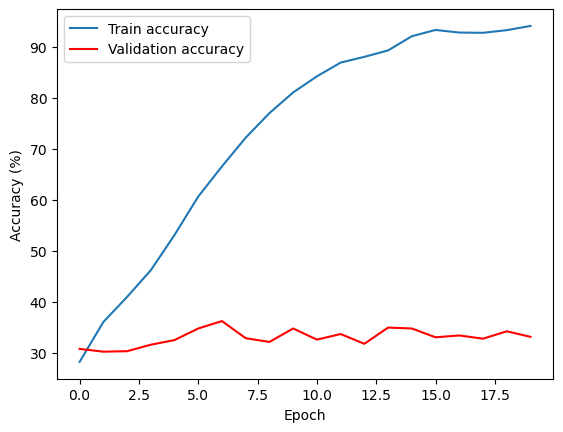

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from matplotlib import pyplot as plt

#plot train accuracy and validation accuracy for every epoch
x = np.arange(0, epochs)
y1 = [train_acc_list[i]  for i in range(epochs)]
y2 = [val_acc_list[i] for i in range(epochs)]

plt.plot(x, y1 ,label = 'Train accuracy')
plt.plot(x, y2, 'r' ,label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [11]:
#get test accuracy

model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 46.50%


<AxesSubplot: >

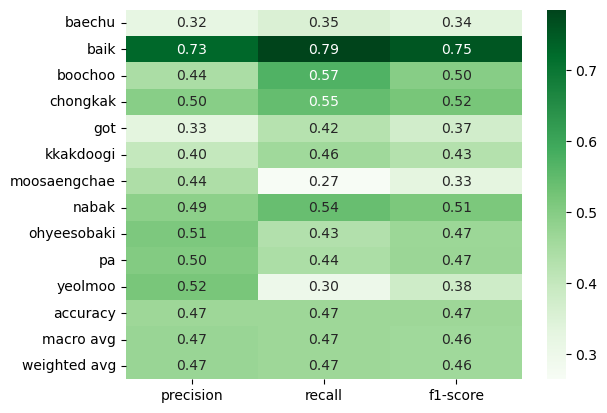

In [13]:
#plot class-wise test accuracy
target_names = ["baechu", "baik", "boochoo", "chongkak", "got", "kkakdoogi", "moosaengchae", "nabak", "ohyeesobaki", "pa", "yeolmoo"]

clf_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Greens", fmt = '.2f')